In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd

PATH_TX = "/content/drive/MyDrive/fraud_detection/transaction_fraud_data.parquet"
PATH_FX = "/content/drive/MyDrive/fraud_detection/historical_currency_exchange.parquet"

df_work = pd.read_parquet(PATH_TX, engine="pyarrow")
df_fx = pd.read_parquet(PATH_FX, engine="pyarrow")

print("Транзакции:", df_work.shape)
print("FX:", df_fx.shape)

Транзакции: (7483766, 23)
FX: (31, 12)


In [3]:
import pandas as pd
import numpy as np

df_work.columns = df_work.columns.str.strip()

required = ['timestamp','amount','currency','is_fraud']
missing = [c for c in required if c not in df_work.columns]
if missing:
    raise KeyError(f"В транзакциях нет обязательных столбцов: {missing}")

df_work['timestamp'] = pd.to_datetime(df_work['timestamp'], errors='coerce')
df_work['date'] = df_work['timestamp'].dt.normalize()

df_work['hour'] = df_work['timestamp'].dt.hour.astype('Int8')
df_work['day_of_week'] = df_work['timestamp'].dt.dayofweek.astype('Int8')

bool_cols = df_work.select_dtypes(include=['bool']).columns.tolist()
for c in bool_cols:
    df_work[c] = df_work[c].astype('Int8')

df_work['is_fraud'] = df_work['is_fraud'].replace(
    {True:1, False:0, 'True':1, 'False':0, '1':1, '0':0}
).astype('Int8')

print("Типы после подготовки:")
print(df_work[['timestamp','date','hour','day_of_week','amount','currency','is_fraud']].dtypes)

Типы после подготовки:
timestamp      datetime64[us]
date           datetime64[us]
hour                     Int8
day_of_week              Int8
amount                float64
currency               object
is_fraud                 Int8
dtype: object


In [4]:
# Если колонка присутствует: распаковываем в плоские признаки
if 'last_hour_activity' in df_work.columns:
    # json_normalize корректно извлечёт dict-поля; пропуски станут NaN
    lha = pd.json_normalize(df_work['last_hour_activity'])
    lha.columns = [f"lha_{c}" for c in lha.columns]
    df_work = pd.concat([df_work.drop(columns=['last_hour_activity']), lha], axis=1)

print("Колонки после распаковки last_hour_activity (если была):")
print([c for c in df_work.columns if c.startswith('lha_')][:10])

Колонки после распаковки last_hour_activity (если была):
['lha_num_transactions', 'lha_total_amount', 'lha_unique_merchants', 'lha_unique_countries', 'lha_max_single_amount']


In [5]:
df_fx = df_fx.copy()
df_fx['date'] = pd.to_datetime(df_fx['date'], errors='coerce').dt.normalize()

fx_long = df_fx.melt(id_vars=['date'], var_name='currency', value_name='fx_to_usd')

df_work = df_work.merge(fx_long, on=['date','currency'], how='left')

df_work['amount_usd'] = np.where(
    df_work['currency'] == 'USD',
    df_work['amount'],
    df_work['amount'] / df_work['fx_to_usd']
)

coverage = df_work['amount_usd'].notna().mean()
print(f"Доля транзакций с успешно рассчитанным amount_usd: {coverage:.2%}")

Доля транзакций с успешно рассчитанным amount_usd: 100.00%


Общая доля мошенничества: 19.97%


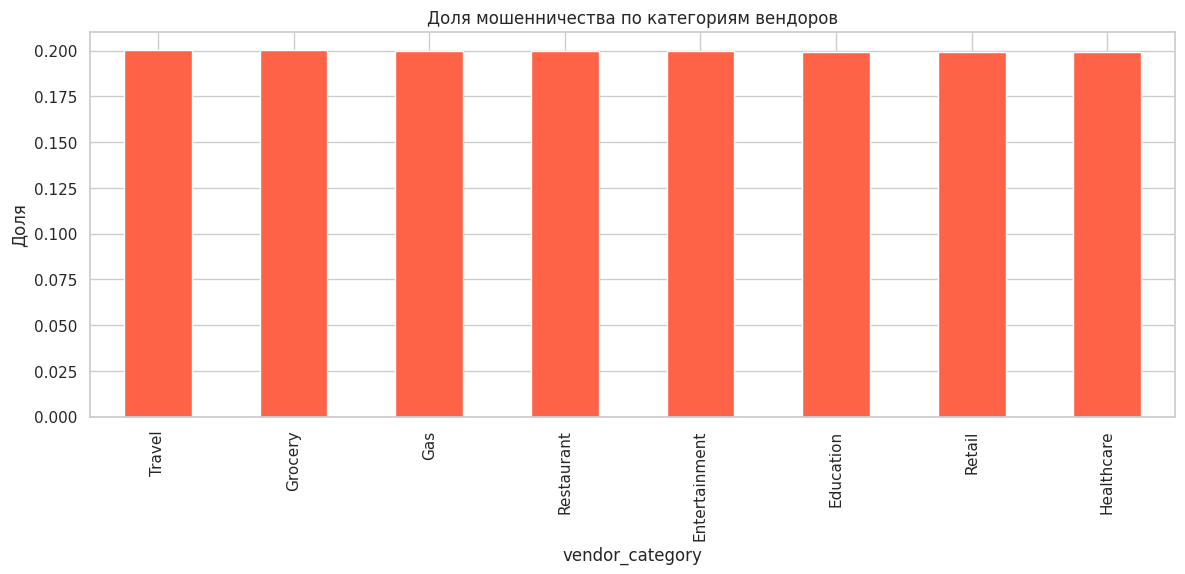

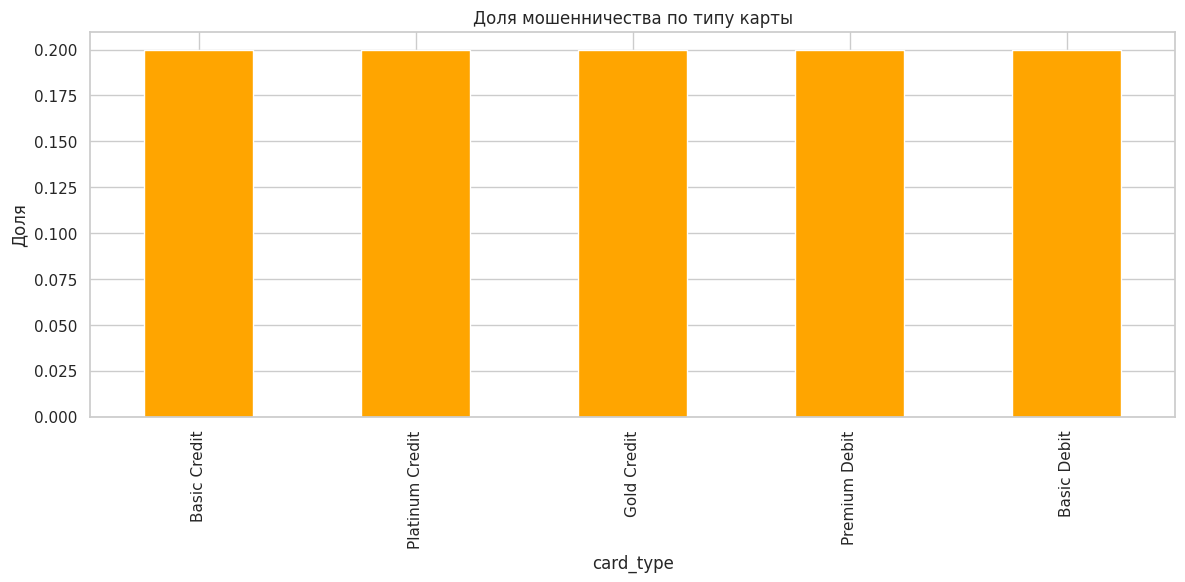

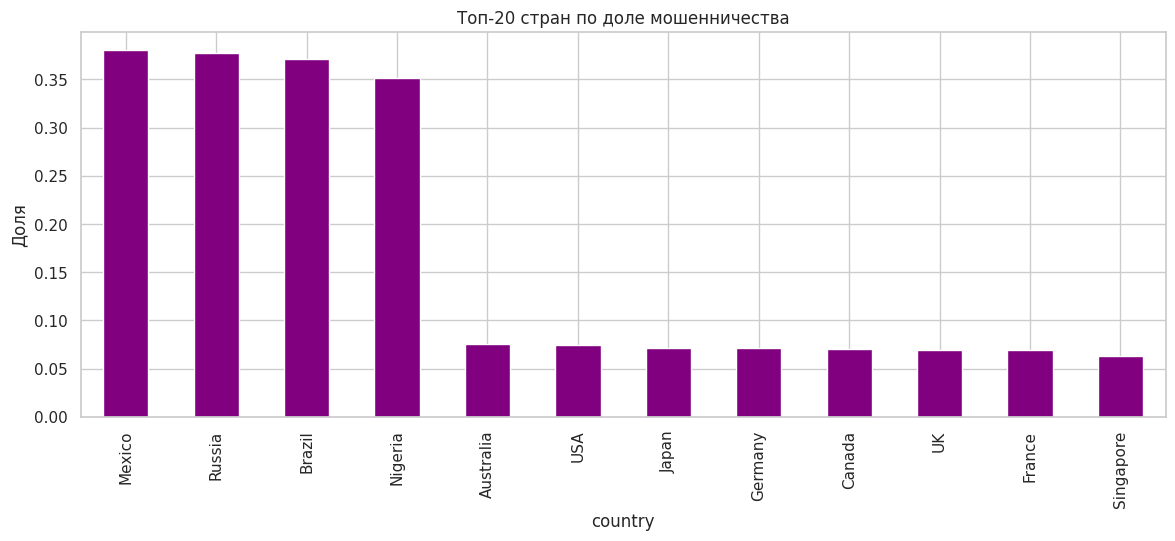

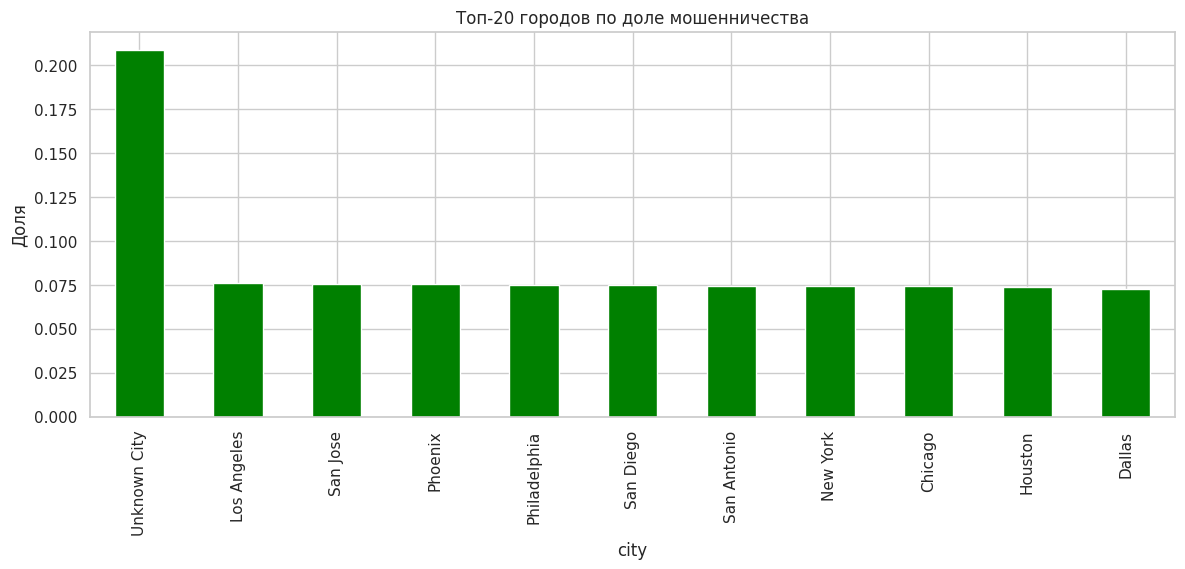

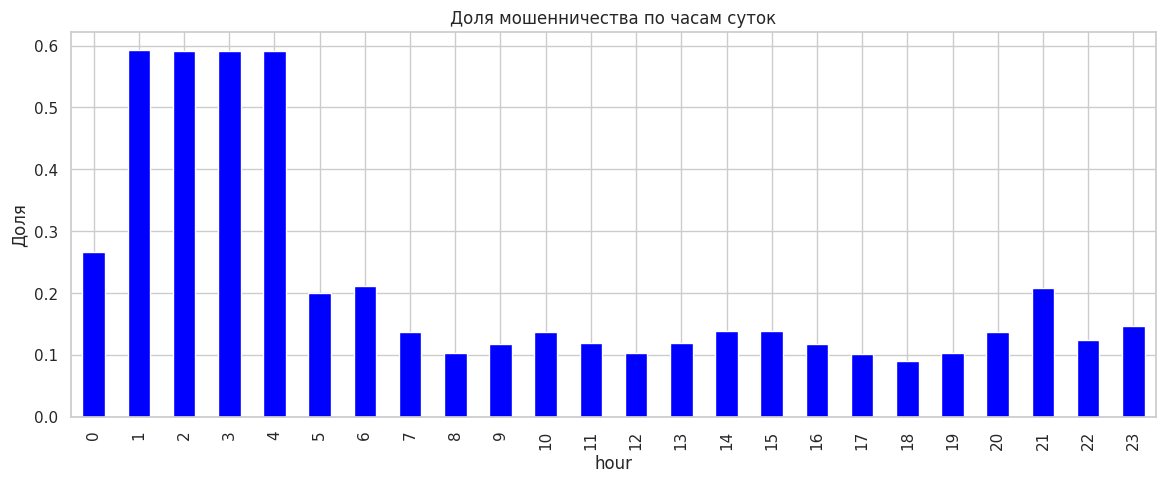

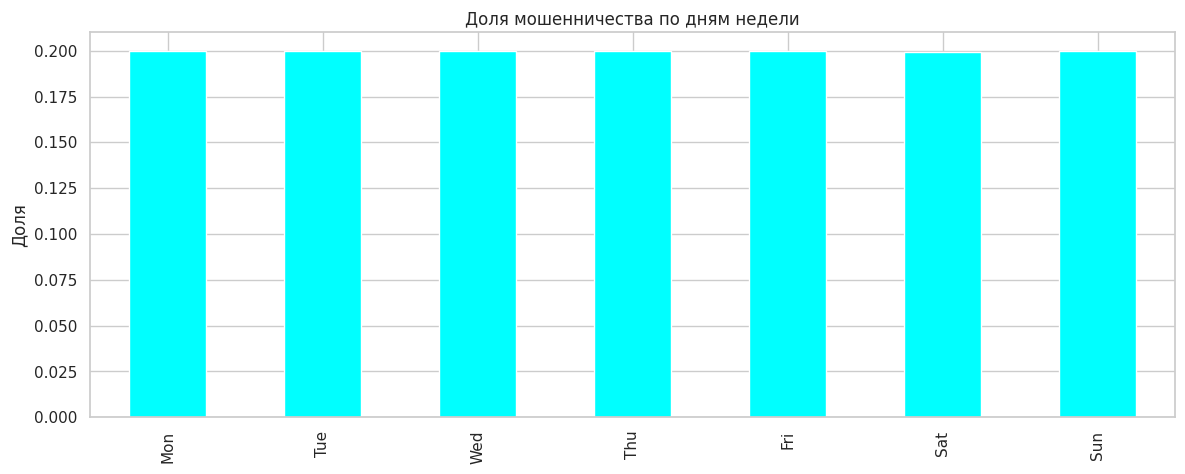

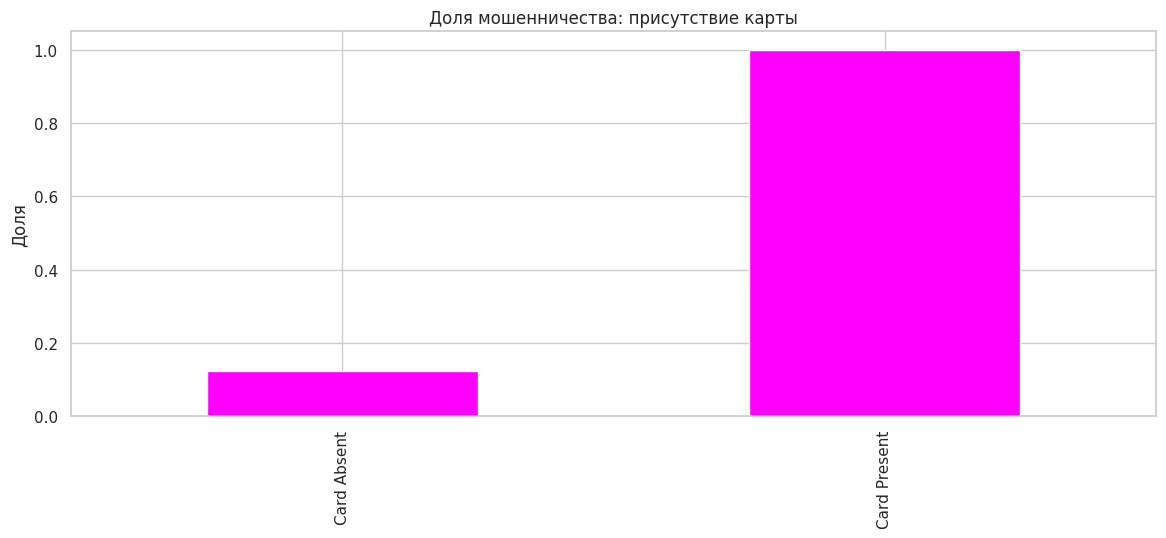

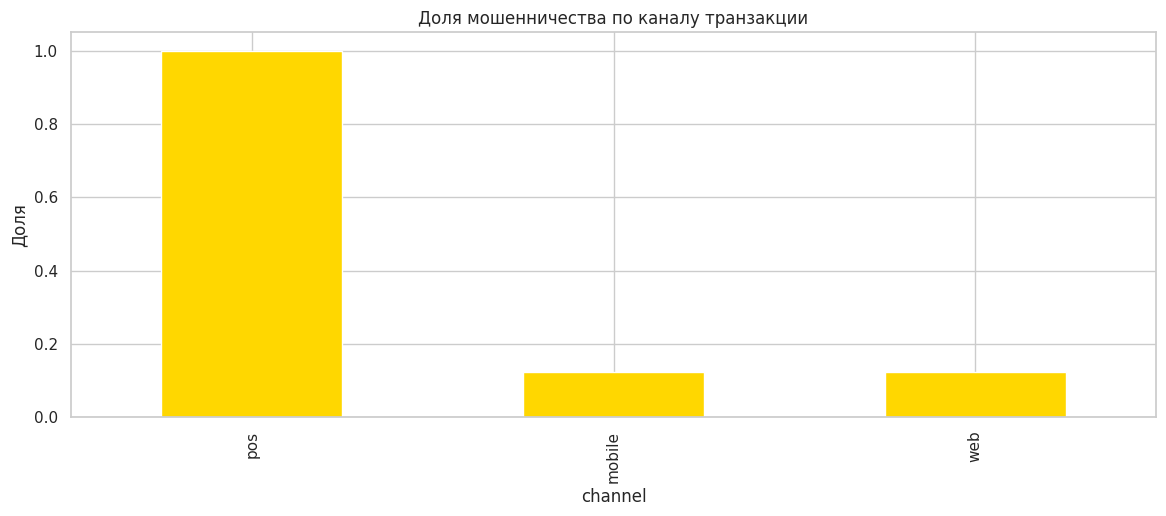

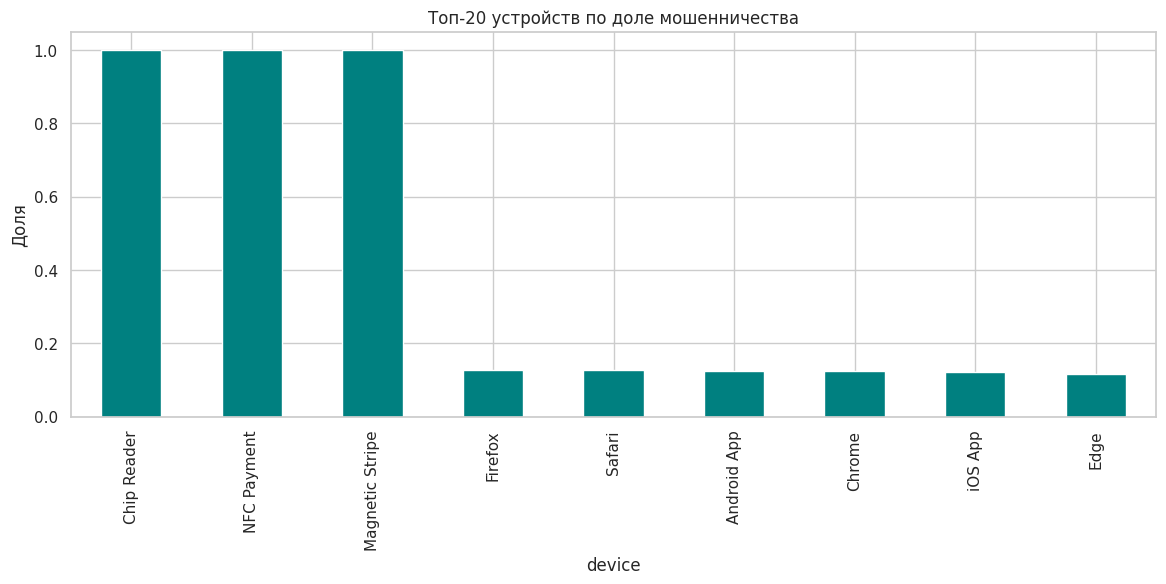

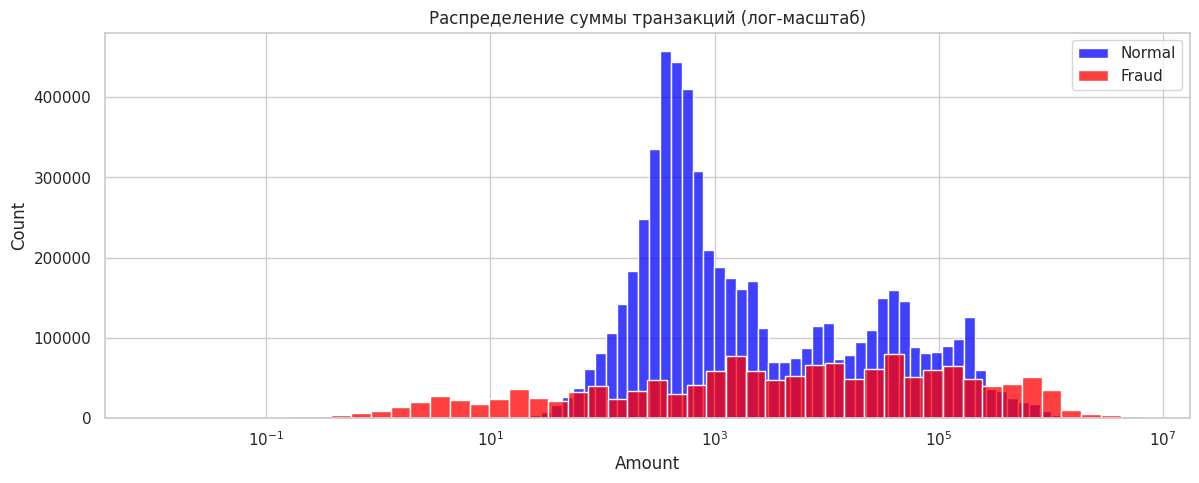

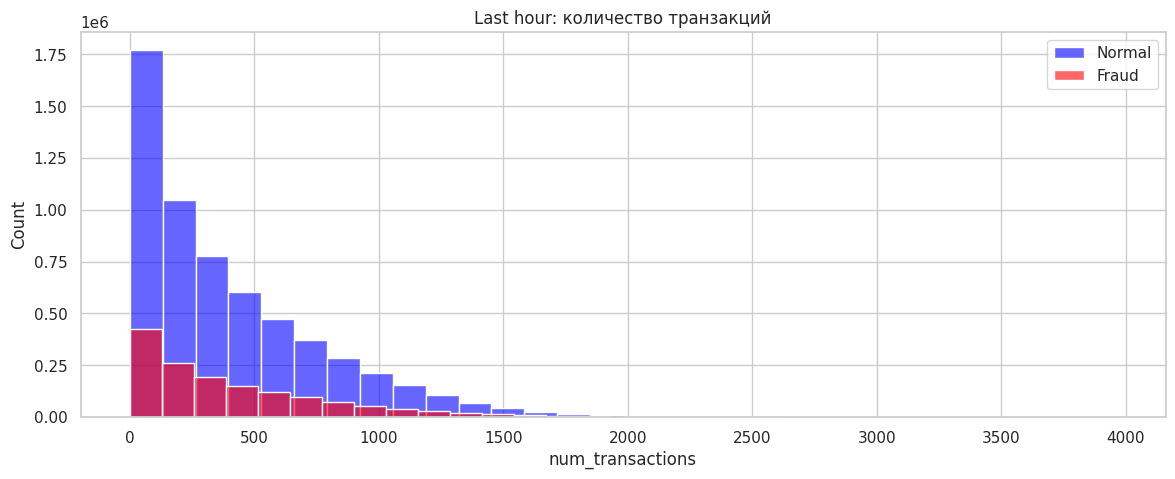

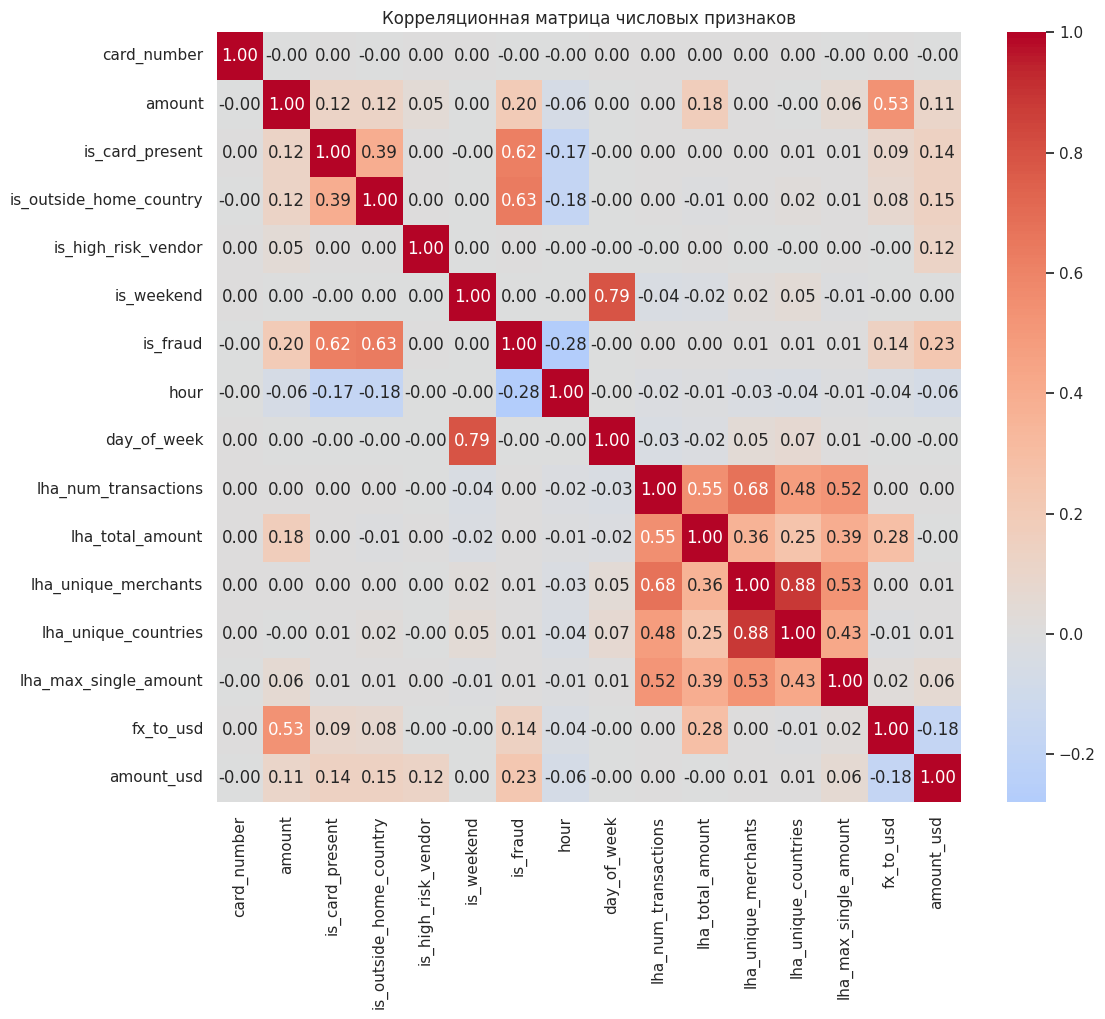

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 5)

fraud_rate = df_work['is_fraud'].mean()
print(f"Общая доля мошенничества: {fraud_rate:.2%}")

vendor_fraud = df_work.groupby('vendor_category')['is_fraud'].mean().sort_values(ascending=False)
vendor_fraud.plot(kind='bar', color='tomato')
plt.title("Доля мошенничества по категориям вендоров")
plt.ylabel("Доля")
plt.show()

card_fraud = df_work.groupby('card_type')['is_fraud'].mean().sort_values(ascending=False)
card_fraud.plot(kind='bar', color='orange')
plt.title("Доля мошенничества по типу карты")
plt.ylabel("Доля")
plt.show()

country_fraud = df_work.groupby('country')['is_fraud'].mean().sort_values(ascending=False).head(20)
country_fraud.plot(kind='bar', color='purple')
plt.title("Топ-20 стран по доле мошенничества")
plt.ylabel("Доля")
plt.show()

city_fraud = df_work.groupby('city')['is_fraud'].mean().sort_values(ascending=False).head(20)
city_fraud.plot(kind='bar', color='green')
plt.title("Топ-20 городов по доле мошенничества")
plt.ylabel("Доля")
plt.show()

hour_fraud = df_work.groupby('hour')['is_fraud'].mean()
hour_fraud.plot(kind='bar', color='blue')
plt.title("Доля мошенничества по часам суток")
plt.ylabel("Доля")
plt.show()

dow_fraud = df_work.groupby('day_of_week')['is_fraud'].mean()
dow_fraud.index = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
dow_fraud.plot(kind='bar', color='cyan')
plt.title("Доля мошенничества по дням недели")
plt.ylabel("Доля")
plt.show()

pos_fraud = df_work.groupby('is_card_present')['is_fraud'].mean()
pos_fraud.index = ['Card Absent','Card Present']
pos_fraud.plot(kind='bar', color='magenta')
plt.title("Доля мошенничества: присутствие карты")
plt.ylabel("Доля")
plt.show()

channel_fraud = df_work.groupby('channel')['is_fraud'].mean().sort_values(ascending=False)
channel_fraud.plot(kind='bar', color='gold')
plt.title("Доля мошенничества по каналу транзакции")
plt.ylabel("Доля")
plt.show()

device_fraud = df_work.groupby('device')['is_fraud'].mean().sort_values(ascending=False).head(20)
device_fraud.plot(kind='bar', color='teal')
plt.title("Топ-20 устройств по доле мошенничества")
plt.ylabel("Доля")
plt.show()

plt.figure(figsize=(14,5))
sns.histplot(df_work[df_work['is_fraud']==0]['amount'], bins=50, color='blue', label='Normal', log_scale=True)
sns.histplot(df_work[df_work['is_fraud']==1]['amount'], bins=50, color='red', label='Fraud', log_scale=True)
plt.title("Распределение суммы транзакций (лог-масштаб)")
plt.xlabel("Amount")
plt.ylabel("Count")
plt.legend()
plt.show()

if any(c.startswith('lha_') for c in df_work.columns):
    sns.histplot(df_work[df_work['is_fraud']==0]['lha_num_transactions'], bins=30, color='blue', label='Normal', alpha=0.6)
    sns.histplot(df_work[df_work['is_fraud']==1]['lha_num_transactions'], bins=30, color='red', label='Fraud', alpha=0.6)
    plt.title("Last hour: количество транзакций")
    plt.xlabel("num_transactions")
    plt.ylabel("Count")
    plt.legend()
    plt.show()

num_cols = df_work.select_dtypes(include=[np.number])
corr_matrix = num_cols.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Корреляционная матрица числовых признаков")
plt.show()



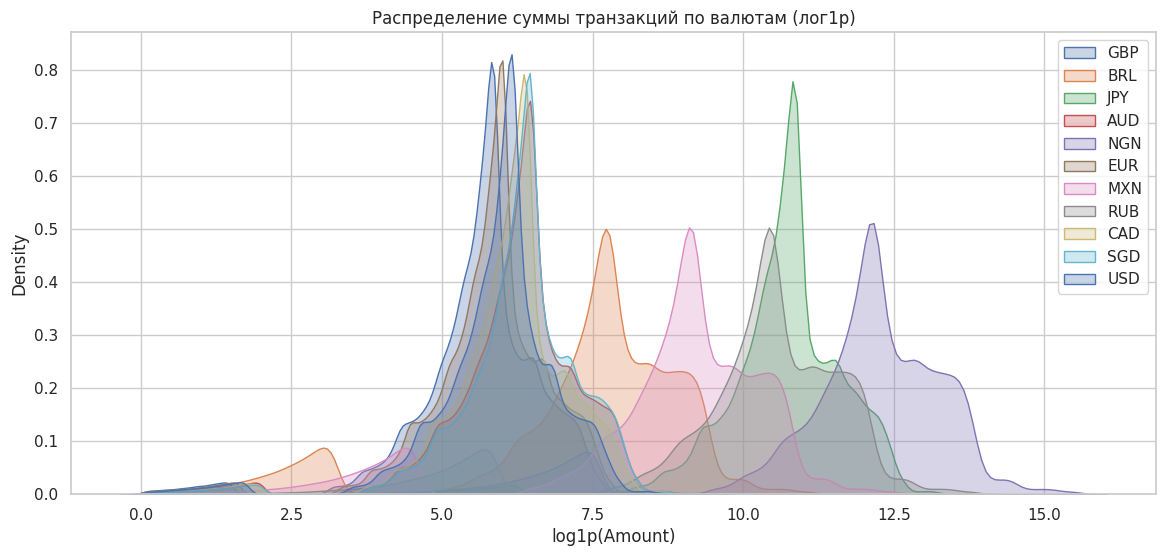

<Figure size 1400x500 with 0 Axes>

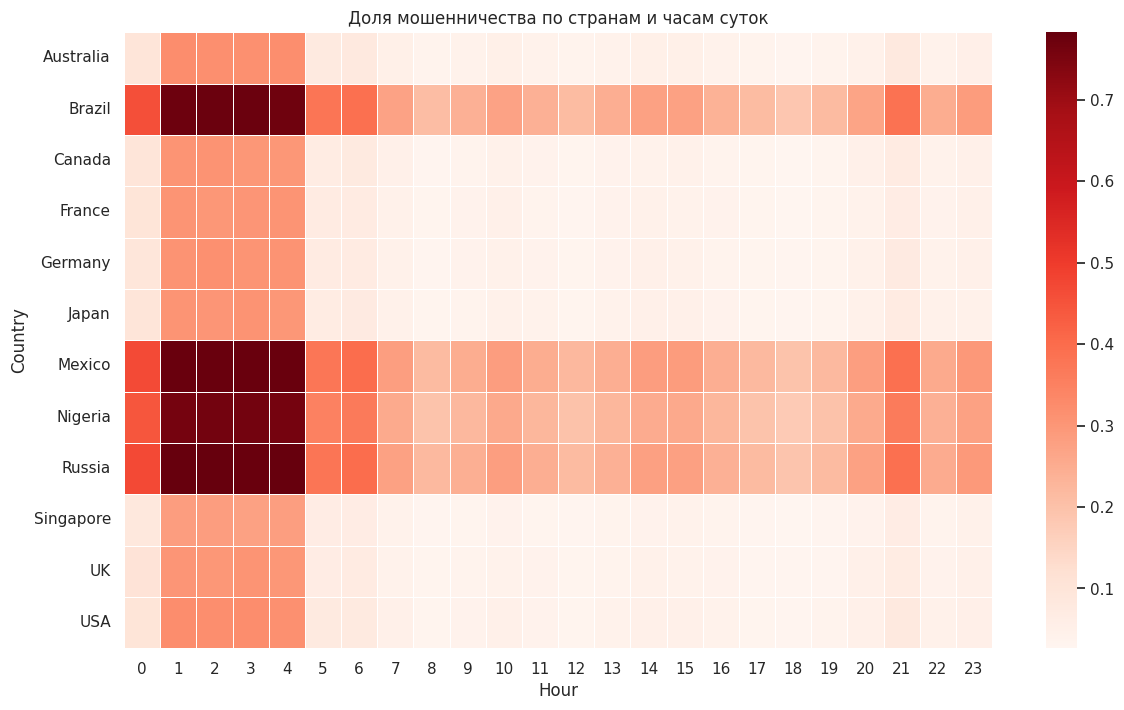

<Figure size 1400x500 with 0 Axes>

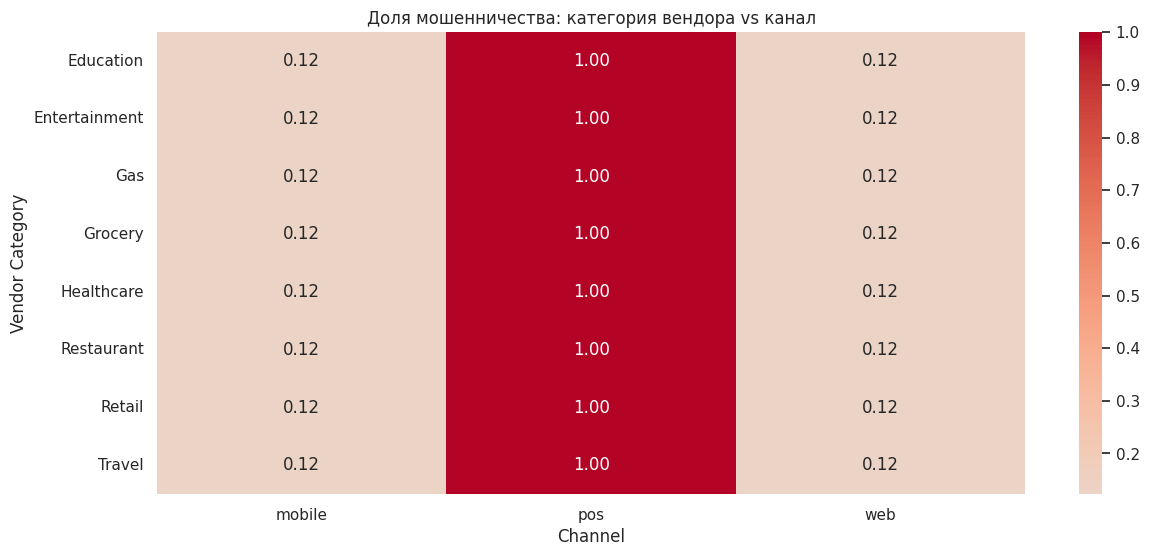

<Figure size 1400x500 with 0 Axes>

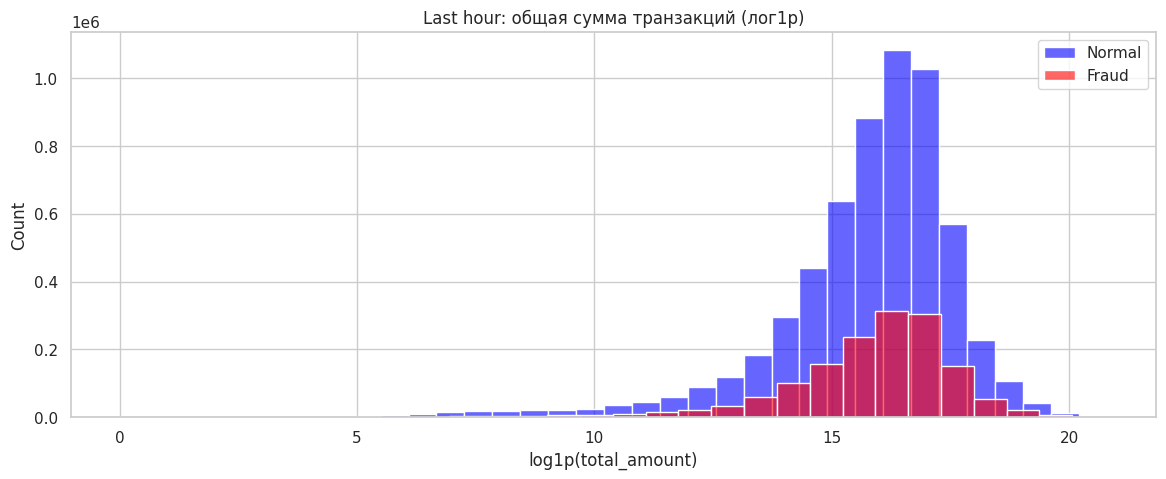

<Figure size 1400x500 with 0 Axes>

In [7]:
plt.figure(figsize=(14,6))
currencies = df_work['currency'].dropna().unique()
for cur in currencies:
    amounts = df_work.loc[df_work['currency']==cur, 'amount'].dropna()
    if not amounts.empty:
        sns.kdeplot(np.log1p(amounts), label=cur, fill=True, alpha=0.3)
plt.title("Распределение суммы транзакций по валютам (лог1p)")
plt.xlabel("log1p(Amount)")
plt.ylabel("Density")
plt.legend()
plt.show()
plt.clf()


country_hour_fraud = (
    df_work.groupby(['country','hour'])['is_fraud']
    .mean()
    .unstack(fill_value=0)
    .astype(float)
)
plt.figure(figsize=(14,8))
sns.heatmap(country_hour_fraud, cmap="Reds", linewidths=0.5)
plt.title("Доля мошенничества по странам и часам суток")
plt.xlabel("Hour")
plt.ylabel("Country")
plt.show()
plt.clf()


vendor_channel_fraud = (
    df_work.groupby(['vendor_category','channel'])['is_fraud']
    .mean()
    .unstack(fill_value=0)
    .astype(float)
)
plt.figure(figsize=(14,6))
sns.heatmap(vendor_channel_fraud, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Доля мошенничества: категория вендора vs канал")
plt.xlabel("Channel")
plt.ylabel("Vendor Category")
plt.show()
plt.clf()

if 'lha_total_amount' in df_work.columns:
    plt.figure(figsize=(14,5))
    for label, color, mask in zip(['Normal','Fraud'], ['blue','red'], [0,1]):
        vals = df_work.loc[df_work['is_fraud']==mask, 'lha_total_amount'].dropna()
        if not vals.empty:
            sns.histplot(np.log1p(vals), bins=30, color=color, label=label, alpha=0.6)
    plt.title("Last hour: общая сумма транзакций (лог1p)")
    plt.xlabel("log1p(total_amount)")
    plt.ylabel("Count")
    plt.legend()
    plt.show()
    plt.clf()


Топ признаков по |corr| с is_fraud:


,is_fraud
is_outside_home_country,6.344586e-01
is_card_present,6.178862e-01
hour,2.796239e-01
amount,1.993418e-01
is_high_risk_vendor,3.729181e-04
is_weekend,2.590952e-05
day_of_week,8.046888e-06
card_number,8.502612e-07


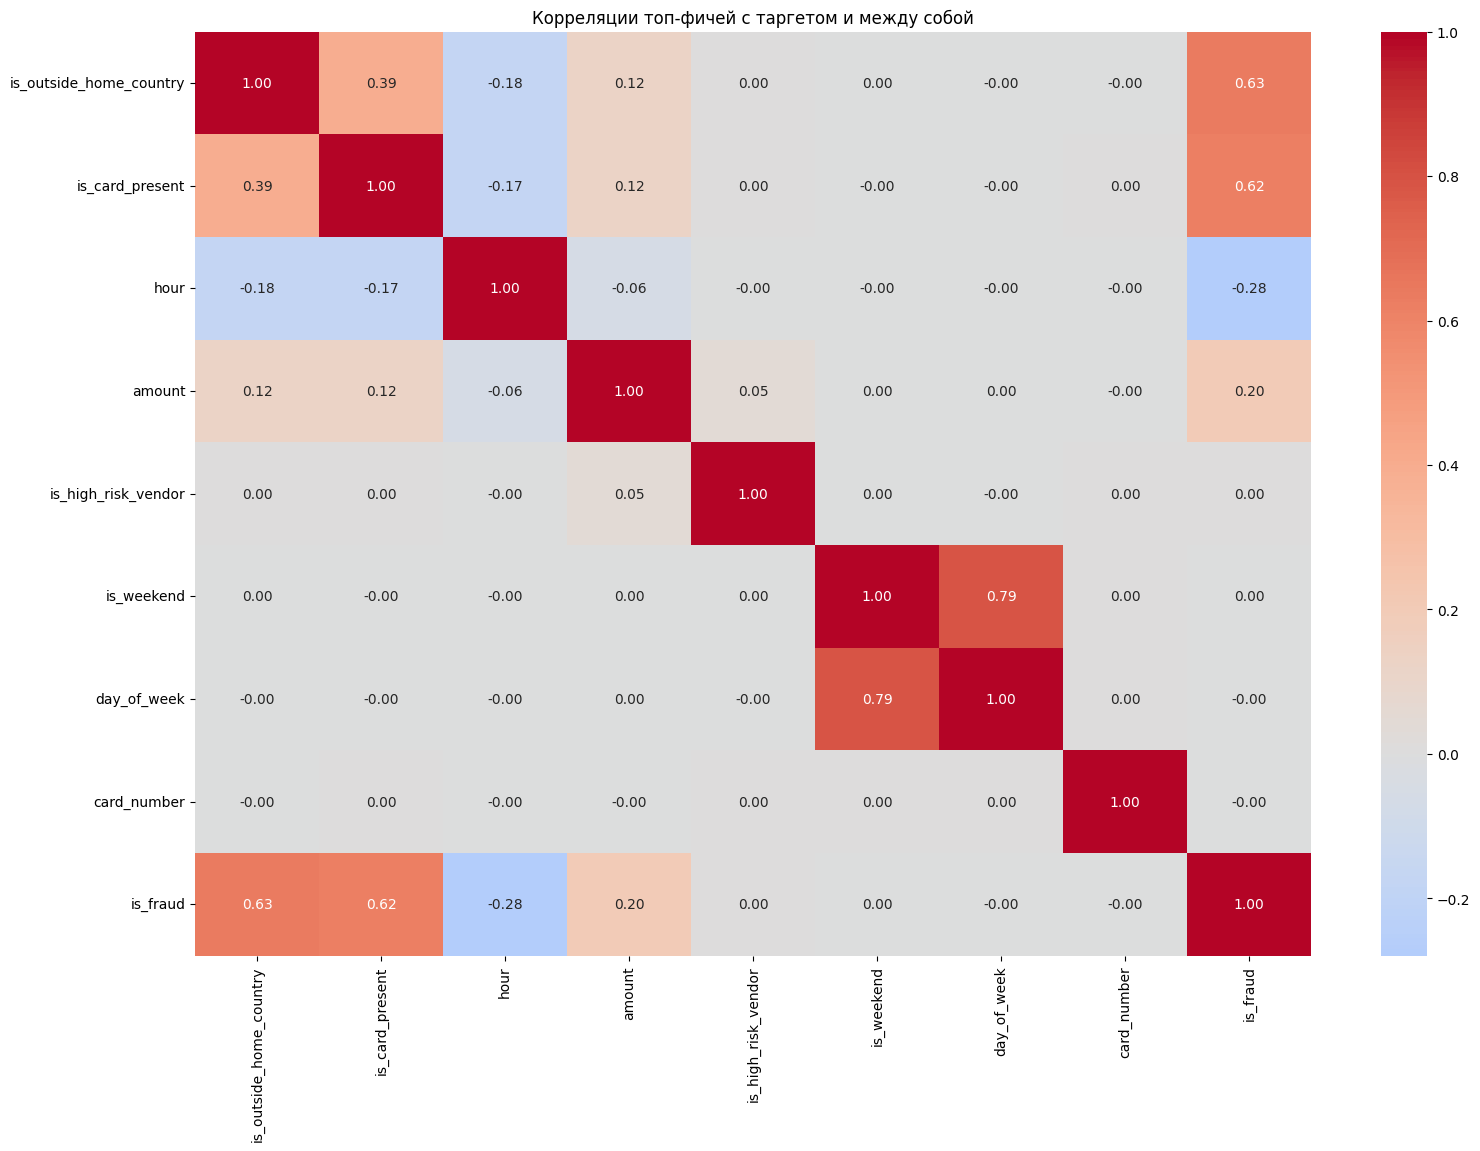

Общая доля мошенничества: 19.97%


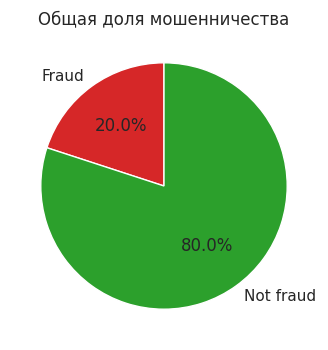

/tmp/ipython-input-4124715816.py:19: RuntimeWarning: Engine has switched to 'python' because numexpr does not support extension array dtypes. Please set your engine to python manually.
  ).query("n >= 50").sort_values('fraud_rate', ascending=False).head(10)
/tmp/ipython-input-4124715816.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


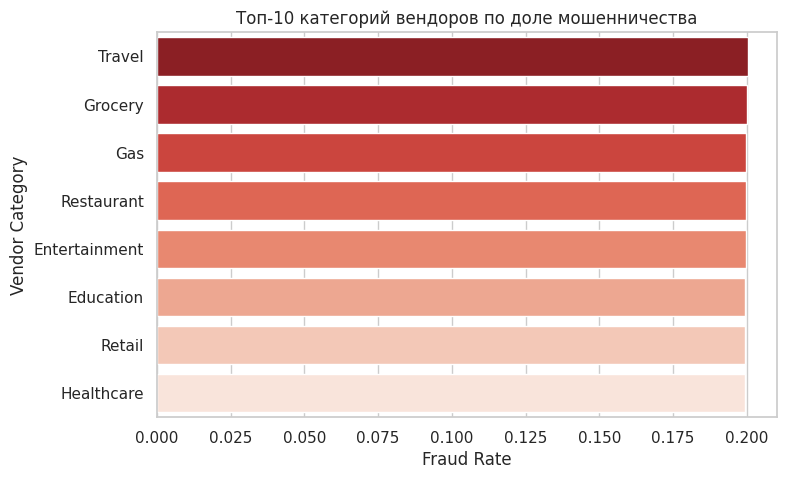

/tmp/ipython-input-4124715816.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


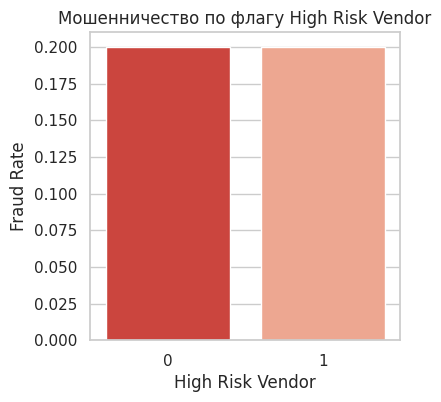

/tmp/ipython-input-4124715816.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


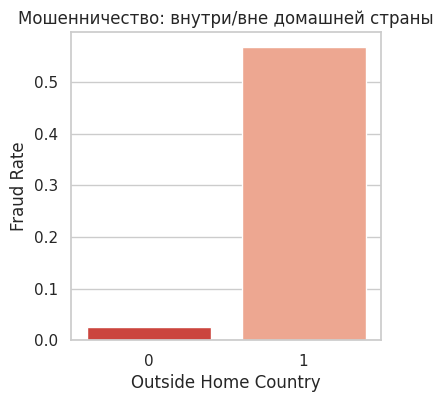

/tmp/ipython-input-4124715816.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


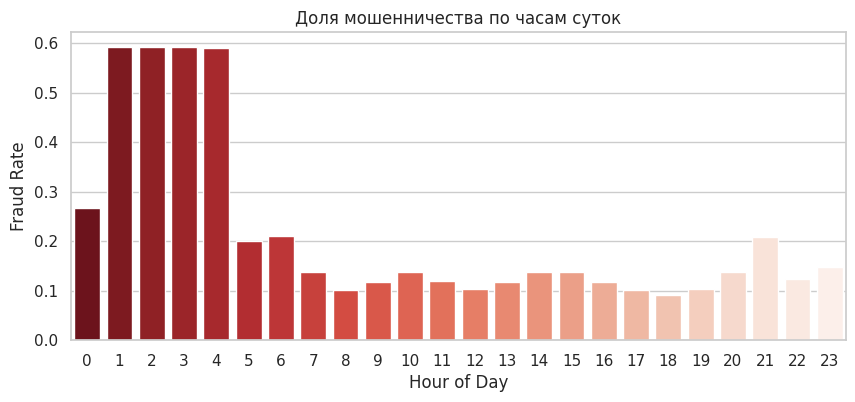

/tmp/ipython-input-4124715816.py:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


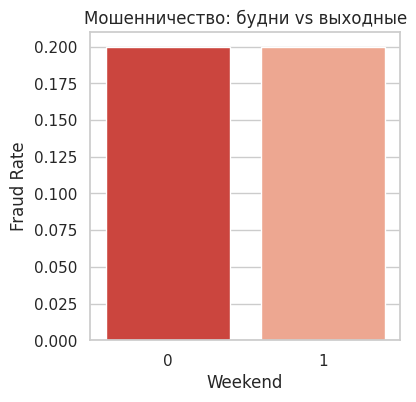

/tmp/ipython-input-4124715816.py:106: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


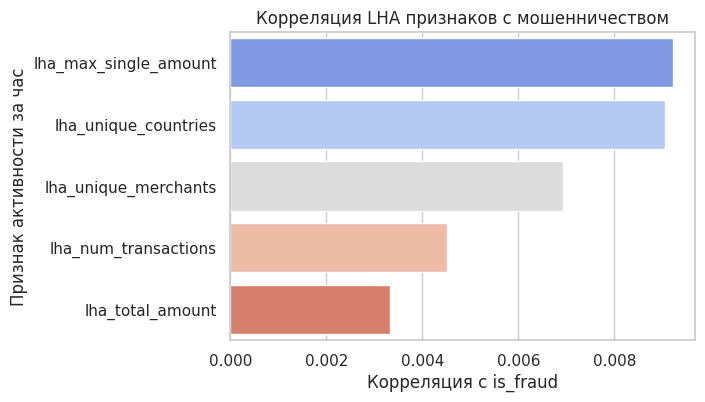

In [9]:
fraud_rate = df_work['is_fraud'].mean()
print(f"Общая доля мошенничества: {fraud_rate:.2%}")

plt.figure(figsize=(4,4))
plt.pie(
    [fraud_rate, 1 - fraud_rate],
    labels=["Fraud", "Not fraud"],
    autopct='%1.1f%%',
    startangle=90,
    colors=["#d62728", "#2ca02c"]
)
plt.title("Общая доля мошенничества")
plt.show()


top_vendors = df_work.groupby('vendor_category').agg(
    fraud_rate=('is_fraud','mean'),
    n=('is_fraud','size')
).query("n >= 50").sort_values('fraud_rate', ascending=False).head(10)

plt.figure(figsize=(8,5))
sns.barplot(
    x=top_vendors['fraud_rate'],
    y=top_vendors.index,
    palette="Reds_r"
)
plt.xlabel("Fraud Rate")
plt.ylabel("Vendor Category")
plt.title("Топ-10 категорий вендоров по доле мошенничества")
plt.show()


if 'is_high_risk_vendor' in df_work.columns:
    risk_stats = df_work.groupby('is_high_risk_vendor')['is_fraud'].mean()

    plt.figure(figsize=(4,4))
    sns.barplot(
        x=risk_stats.index.astype(str),
        y=risk_stats.values,
        palette="Reds_r"
    )
    plt.xlabel("High Risk Vendor")
    plt.ylabel("Fraud Rate")
    plt.title("Мошенничество по флагу High Risk Vendor")
    plt.show()


if 'is_outside_home_country' in df_work.columns:
    outside_stats = df_work.groupby('is_outside_home_country')['is_fraud'].mean()

    plt.figure(figsize=(4,4))
    sns.barplot(
        x=outside_stats.index.astype(str),
        y=outside_stats.values,
        palette="Reds_r"
    )
    plt.xlabel("Outside Home Country")
    plt.ylabel("Fraud Rate")
    plt.title("Мошенничество: внутри/вне домашней страны")
    plt.show()


hourly_stats = (
    df_work.groupby('hour')['is_fraud']
    .mean()
    .reindex(range(24), fill_value=0)
)

plt.figure(figsize=(10,4))
sns.barplot(
    x=hourly_stats.index,
    y=hourly_stats.values,
    palette="Reds_r"
)
plt.xlabel("Hour of Day")
plt.ylabel("Fraud Rate")
plt.title("Доля мошенничества по часам суток")
plt.show()


if 'is_weekend' in df_work.columns:
    weekend_stats = df_work.groupby('is_weekend')['is_fraud'].mean()

    plt.figure(figsize=(4,4))
    sns.barplot(
        x=weekend_stats.index.astype(str),
        y=weekend_stats.values,
        palette="Reds_r"
    )
    plt.xlabel("Weekend")
    plt.ylabel("Fraud Rate")
    plt.title("Мошенничество: будни vs выходные")
    plt.show()


lha_cols = [c for c in df_work.columns if c.startswith('lha_')]
if lha_cols:
    corr = (
        df_work[lha_cols + ['is_fraud']]
        .corr(numeric_only=True)['is_fraud']
        .drop('is_fraud')
        .sort_values(key=abs, ascending=False)
    )

    plt.figure(figsize=(6,4))
    sns.barplot(
        x=corr.values,
        y=corr.index,
        palette="coolwarm"
    )
    plt.xlabel("Корреляция с is_fraud")
    plt.ylabel("Признак активности за час")
    plt.title("Корреляция LHA признаков с мошенничеством")
    plt.show()


/tmp/ipython-input-3354097058.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fraud_rate_by_bin = df_plot.groupby('log_bin')['is_fraud'].mean()


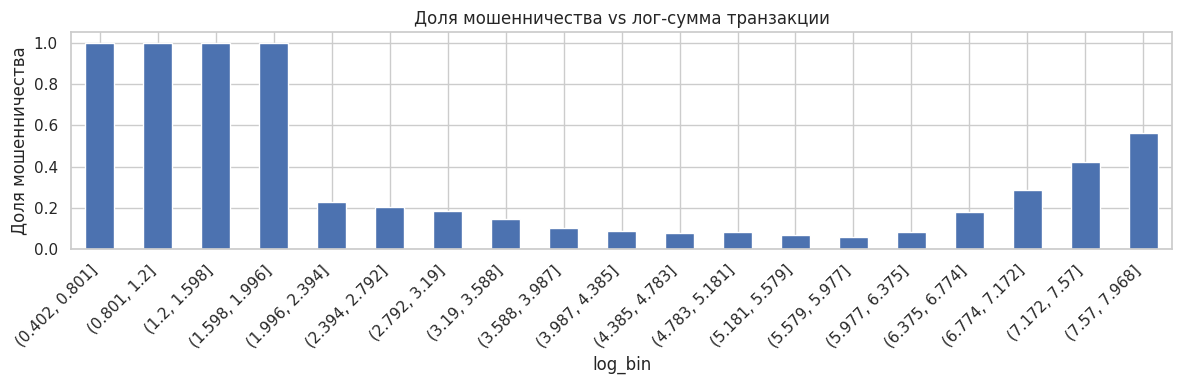

In [10]:
amount_col = 'amount_usd' if 'amount_usd' in df_work.columns else 'amount'

df_plot = df_work[[amount_col, 'hour', 'is_fraud']].dropna().copy()
df_plot['log_amount'] = np.log1p(df_plot[amount_col])

bins = np.linspace(df_plot['log_amount'].quantile(0.01),
                   df_plot['log_amount'].quantile(0.99), 20)
df_plot['log_bin'] = pd.cut(df_plot['log_amount'], bins=bins, include_lowest=True)

fraud_rate_by_bin = df_plot.groupby('log_bin')['is_fraud'].mean()

plt.figure(figsize=(12,4))
fraud_rate_by_bin.plot(kind='bar')
plt.ylabel("Доля мошенничества")
plt.title("Доля мошенничества vs лог-сумма транзакции")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [11]:
nan_rate = df_work['amount_usd'].isna().mean()
print(f"Доля транзакций без amount_usd: {nan_rate:.2%}")

currency_stats = df_work.groupby('currency')['amount_usd'].agg(
    total_transactions='size',
    non_na_transactions='count'
)
currency_stats['na_count'] = currency_stats['total_transactions'] - currency_stats['non_na_transactions']
currency_stats['na_rate'] = currency_stats['na_count'] / currency_stats['total_transactions']
currency_stats = currency_stats.sort_values('na_rate', ascending=False)

print("\nПокрытие amount_usd по валютам:")
display(currency_stats)


Доля транзакций без amount_usd: 0.00%

Покрытие amount_usd по валютам:


,total_transactions,non_na_transactions,na_count,na_rate
currency,,,,
AUD,496695,496695,0,0.0
BRL,804800,804800,0,0.0
CAD,532632,532632,0,0.0
EUR,1065751,1065751,0,0.0
GBP,538493,538493,0,0.0
JPY,527393,527393,0,0.0
MXN,785704,785704,0,0.0
NGN,849840,849840,0,0.0
RUB,793730,793730,0,0.0


In [14]:
nan_rate = df_work['amount_usd'].isna().mean()
print(f"Доля транзакций без amount_usd: {nan_rate:.2%}")

currency_stats = df_work.groupby('currency')['amount_usd'].agg(
    total_transactions='size',
    non_na_transactions='count'
)
currency_stats['na_count'] = currency_stats['total_transactions'] - currency_stats['non_na_transactions']
currency_stats['na_rate'] = currency_stats['na_count'] / currency_stats['total_transactions']
currency_stats = currency_stats.sort_values('na_rate', ascending=False)

print("\nПокрытие amount_usd по валютам:")
display(currency_stats)



Доля транзакций без amount_usd: 0.00%

Покрытие amount_usd по валютам:


,total_transactions,non_na_transactions,na_count,na_rate
currency,,,,
AUD,496695,496695,0,0.0
BRL,804800,804800,0,0.0
CAD,532632,532632,0,0.0
EUR,1065751,1065751,0,0.0
GBP,538493,538493,0,0.0
JPY,527393,527393,0,0.0
MXN,785704,785704,0,0.0
NGN,849840,849840,0,0.0
RUB,793730,793730,0,0.0


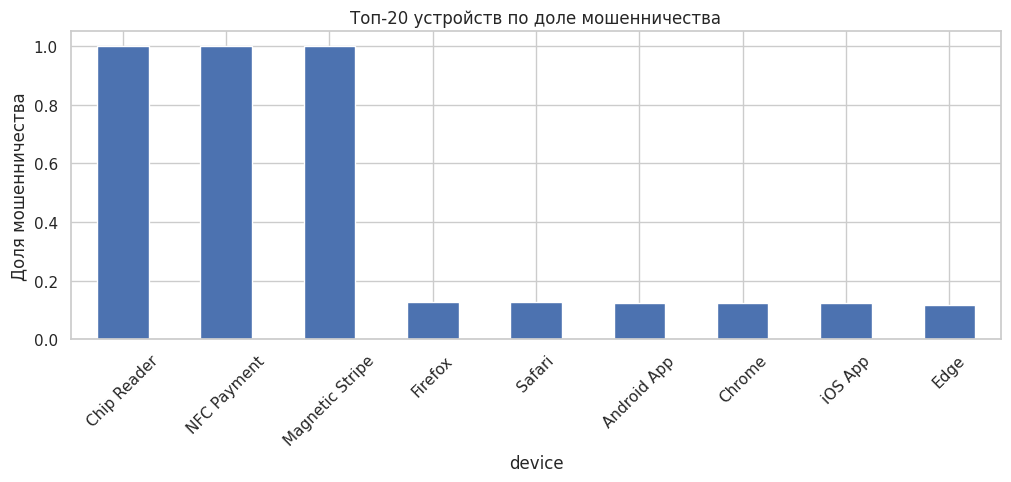

In [12]:
dev_rate = df_work.groupby('device')['is_fraud'].mean().sort_values(ascending=False).head(20)
plt.figure(figsize=(12,4))
dev_rate.plot(kind='bar')
plt.title('Топ-20 устройств по доле мошенничества')
plt.ylabel('Доля мошенничества')
plt.xticks(rotation=45)
plt.show()

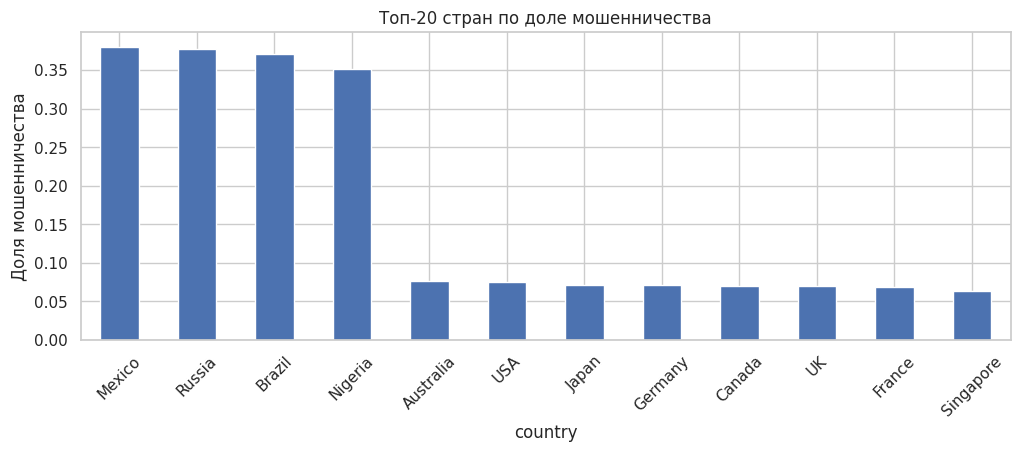

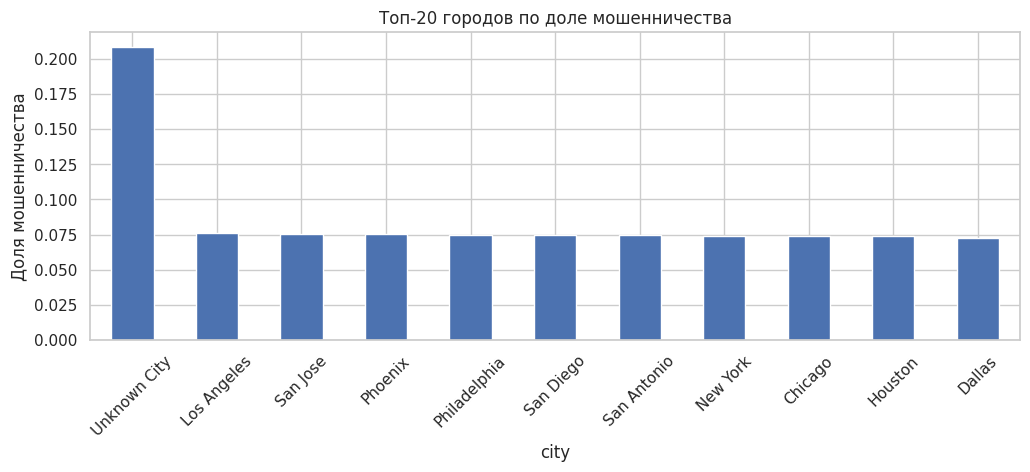

,count
city,
Unknown City,6983706
San Diego,50425
Phoenix,50333
Dallas,50126
San Antonio,50079
San Jose,50015
Houston,49957
Philadelphia,49914
Chicago,49912


In [14]:
country_rate = df_work.groupby('country')['is_fraud'].mean().sort_values(ascending=False).head(20)
plt.figure(figsize=(12,4))
country_rate.plot(kind='bar')
plt.title('Топ-20 стран по доле мошенничества')
plt.ylabel('Доля мошенничества')
plt.xticks(rotation=45)
plt.show()


city_rate = df_work.groupby('city')['is_fraud'].mean().sort_values(ascending=False).head(20)
plt.figure(figsize=(12,4))
city_rate.plot(kind='bar')
plt.title('Топ-20 городов по доле мошенничества')
plt.ylabel('Доля мошенничества')
plt.xticks(rotation=45)
plt.show()

df_work['city'].value_counts()